In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import bemcs
import labeling 

['mbt' 'ramp_mft' 'right_edge' 'topo']


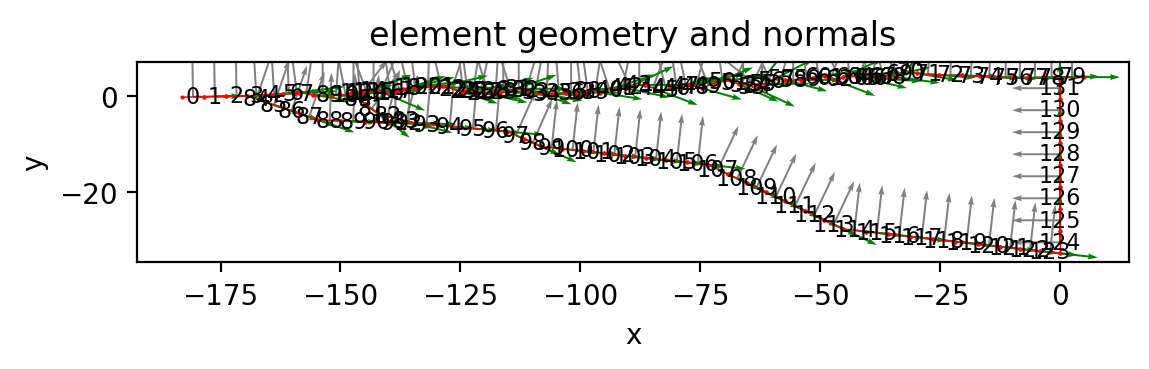

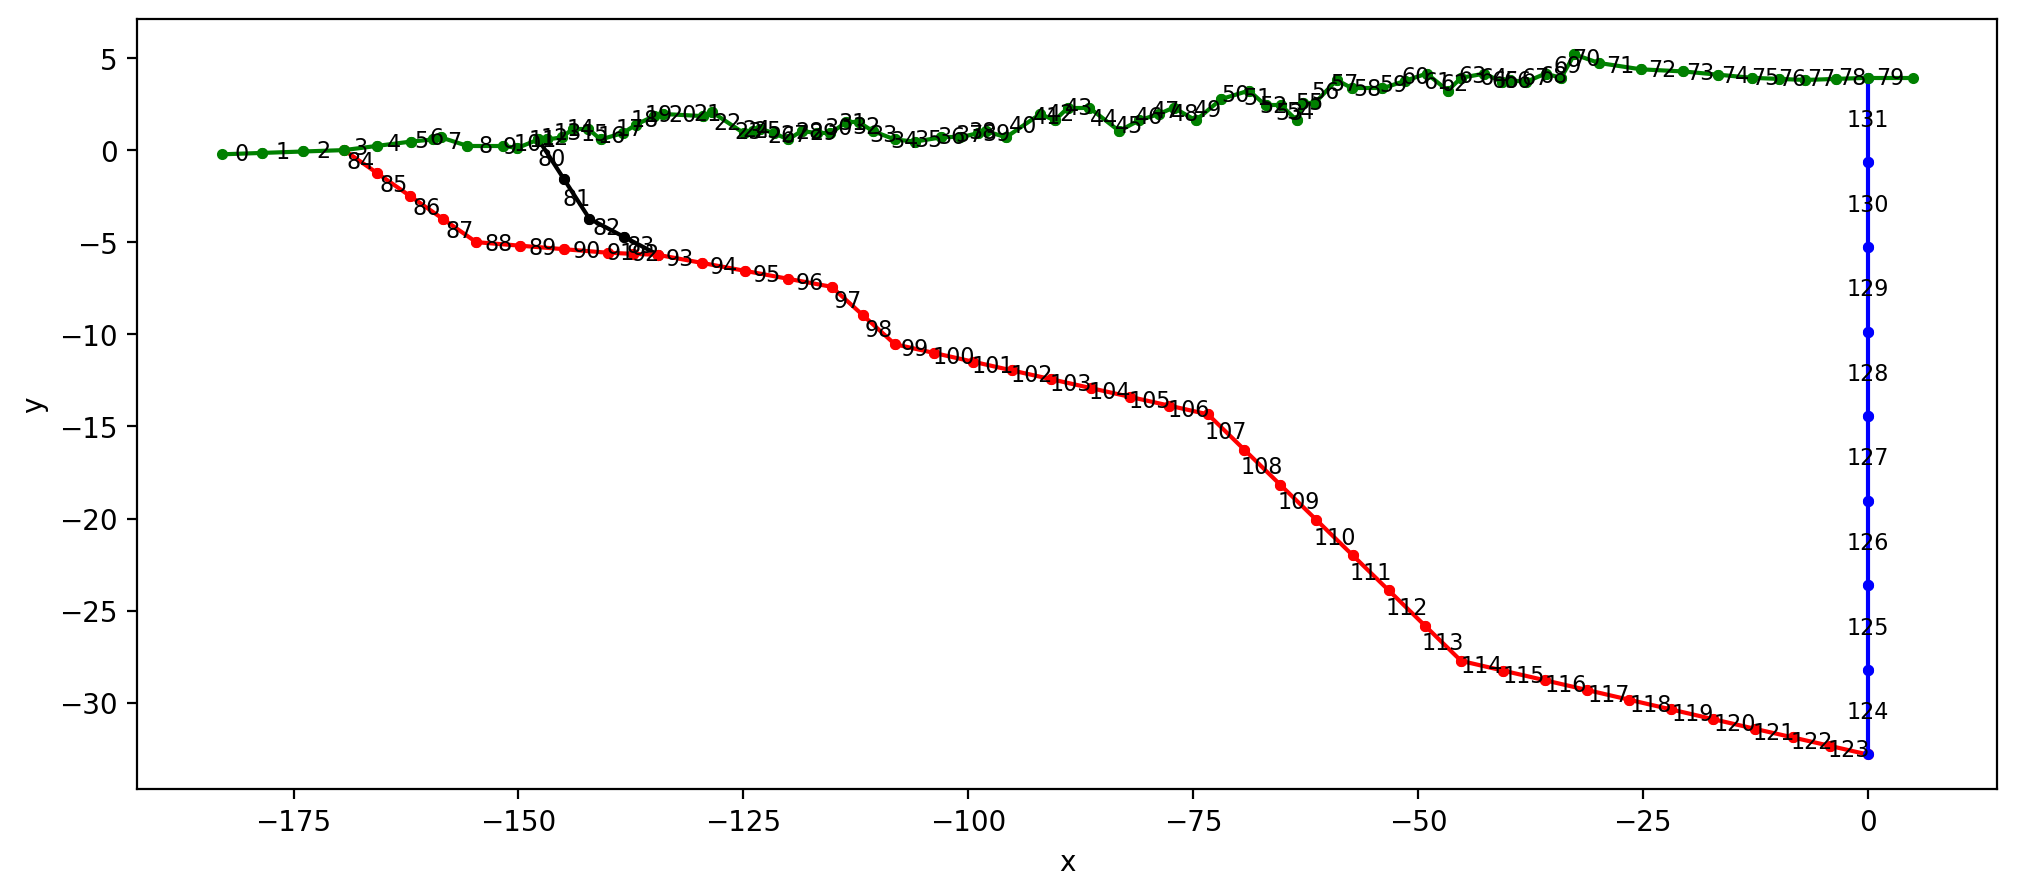

In [2]:
# Elastic parameters
mu = 5
nu = 0.25

# read fault geometry files
# fileinput = pd.read_csv("mht_geometry_5_km.csv")
fileinput = pd.read_csv("mht_geometry_bcs_5_km.csv")
# fileinput = pd.read_csv("dummy_geometry.csv")

# print(fileinput.head())
x1 = fileinput["x1"].values
x2 = fileinput["x2"].values
y1 = fileinput["y1"].values
y2 = fileinput["y2"].values
bc_x = fileinput["bc_x"].values
bc_y = fileinput["bc_y"].values
bctype = fileinput["bc_type"].values

labels = fileinput["collection"].values
print(np.unique(labels))

# create bemcs data structure
els = bemcs.initialize_els()
els.x1 = x1
els.y1 = y1
els.x2 = x2
els.y2 = y2
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
faultid = np.arange(n_els)
bemcs.plot_els_geometry(els)

plt.figure(figsize=(12, 5))
cval = "krbgcym"
count = 0
for i in np.unique(labels):
    index = np.where(labels == i)[0]
    for j in index:
        plt.plot(
            [els.x1[j], els.x2[j]], [els.y1[j], els.y2[j]], ".-", color=cval[count]
        )
        plt.text(
            els.x_centers[j],
            els.y_centers[j],
            str(faultid[j]),
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=8,
        )
    count += 1
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Identifying open nodes, overlapping interior nodes and triple junctions automatically

In [3]:
index_open, index_overlap, index_triple = labeling.label_nodes(els)
N_c = 2 * n_els  # central node equations
N_o = 2 * len(index_open)  # open node equations
N_i = 4 * len(index_overlap)  # overlapping node equations
N_t = 6 * len(index_triple)  # triple junction equations

Number of open nodes = 2
: [array([0]), array([239])]
Number of 2-overlap nodes = 125
: [array([3, 2]), array([6, 5]), array([255, 254]), array([12, 11]), array([258, 257]), array([15, 14]), array([18, 17]), array([21, 20]), array([261, 260]), array([24, 23]), array([264, 263]), array([27, 26]), array([30, 29]), array([267, 266]), array([36, 35]), array([39, 38]), array([243, 242]), array([270, 269]), array([42, 41]), array([45, 44]), array([246, 245]), array([48, 47]), array([273, 272]), array([51, 50]), array([249, 248]), array([276, 275]), array([54, 53]), array([57, 56]), array([60, 59]), array([282, 281]), array([63, 62]), array([66, 65]), array([69, 68]), array([285, 284]), array([72, 71]), array([75, 74]), array([78, 77]), array([81, 80]), array([288, 287]), array([84, 83]), array([87, 86]), array([90, 89]), array([291, 290]), array([93, 92]), array([96, 95]), array([294, 293]), array([99, 98]), array([297, 296]), array([102, 101]), array([105, 104]), array([300, 299]), array([1

In [4]:
Nequations = N_c + N_o + N_i + N_t
Nunknowns = 6 * n_els

# We will stack this with
# equations for the element centers
# equations at open nodes (RHS = 0)
# equations at overlapping nodes (RHS = 0)
# equations at triple junctions (RHS = 0)
BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
BC_o = np.zeros((N_o, 1))
BC_i = np.zeros((N_i, 1))
BC_t = np.zeros((N_t, 1))

# apply BCs at central nodes
BC_c[0::2, 0] = bc_x
BC_c[1::2, 0] = bc_y

# stack all the BCs into 1 big vector
BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

## Design Matrix System 
- At element centers, we implement either displacement or traction boundary conditions
- At open nodes, we force slip to be 0
- At 2-overlap (interior) nodes we have continuity & smoothness of slip
- At triple junctions, we implement 2 equations for conservation of slip and 4 equations for smoothness

We first deal with the matrix system for the central nodes

In [5]:
# Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(els)

# Patch center locations
# (need to be shifted an infinitesimal amount in unit normal direction for displacement bcs)
epsilonr = 1e-4 * (bctype == "u").astype(float)
obs_xy = np.vstack((els.x_centers, els.y_centers)).T
x_obs = (obs_xy[:, 0] + epsilonr * els.x_normals).reshape(-1, 1)
y_obs = (obs_xy[:, 1] + epsilonr * els.y_normals).reshape(-1, 1)

# Compute shear and tensile stress kernels evaluated ONLY at the center of each element
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Convert to traction kernels [Nobs x Ncoefficients]
traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="global")
traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="global")

/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/bemcs/bemcs.py:148: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))


### Assemble linear operator for central nodes only

In [6]:
# Linear operator for central node BCs
kerneleval_x = np.zeros((n_els, Nunknowns))
kerneleval_y = np.zeros((n_els, Nunknowns))

# x,y-kernels
for i in np.unique(labels):
    index = np.where(labels == i)[0]
    for j in index:
        if bctype[j] == "u":
            for k in range(0, 3):
                kerneleval_x[j, k::6] = kernels_s[3][j, k::3]
                kerneleval_x[j, k + 3 :: 6] = kernels_n[3][j, k::3]
                kerneleval_y[j, k::6] = kernels_s[4][j, k::3]
                kerneleval_y[j, k + 3 :: 6] = kernels_n[4][j, k::3]
        elif bctype[j] == "t":
            for k in range(0, 3):
                kerneleval_x[j, k::6] = traction_kernels_s[0][j, k::3]
                kerneleval_x[j, k + 3 :: 6] = traction_kernels_n[0][j, k::3]
                kerneleval_y[j, k::6] = traction_kernels_s[1][j, k::3]
                kerneleval_y[j, k + 3 :: 6] = traction_kernels_n[1][j, k::3]
        elif bctype[j] == "s":
            # print(j)
            kerneleval_x[j, :] = matrix_slip[2::6, :][j, :]
            kerneleval_y[j, :] = matrix_slip[3::6, :][j, :]

# Linear Operators for the appropriate boundary conditions
matrix_system_c = np.zeros((N_c, Nunknowns))
# populate matrix_system for central nodes
matrix_system_c[0::2, :] = kerneleval_x
matrix_system_c[1::2, :] = kerneleval_y

### Open nodes, overlapping nodes & triple junctions

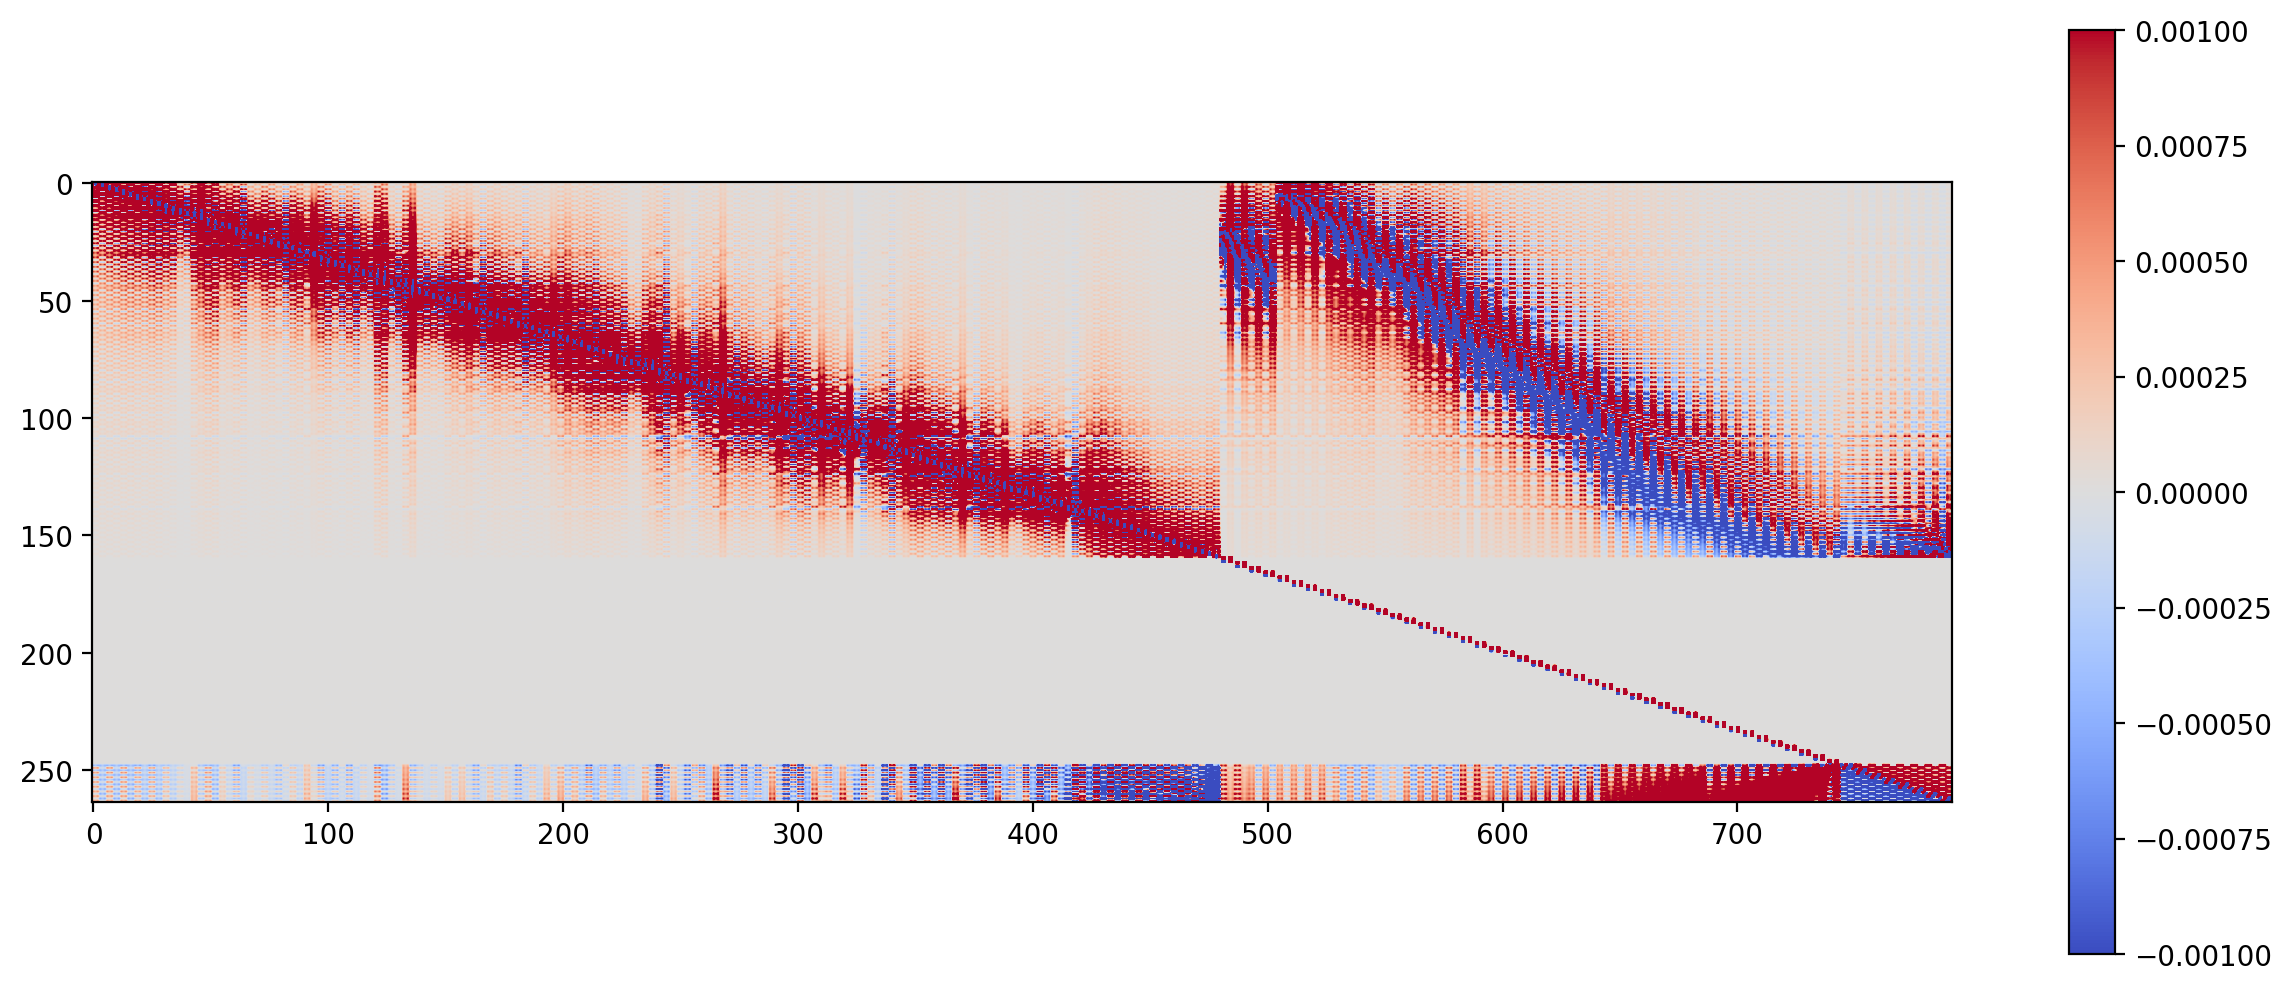

In [7]:
matrix_system_o, matrix_system_i, matrix_system_t = labeling.construct_smoothoperator(
    els, index_open, index_overlap, index_triple
)

# stack the matrices and create the full linear operator
matrix_system = np.vstack(
    (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
)
# plot design matrix
plt.figure(figsize=(15, 6))
plt.imshow(matrix_system_c, cmap="coolwarm")
plt.colorbar()
plt.clim(-0.001, 0.001)
plt.show()

# Solve system

In [13]:
# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
# quadratic_coefs = np.linalg.lstsq(matrix_system, BCvector, rcond=None)[0]
print("Linear Operator Condition Number:", np.linalg.cond(matrix_system))

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((3 * n_els, 1))
quadratic_coefs_n = np.zeros((3 * n_els, 1))
for i in range(n_els):
    quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
    quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]

Linear Operator Condition Number: 1555.3961398170345


## Plot displacement and stress components in the medium

In [9]:
# Observation points
n_obs = 100
x_obs = np.linspace(-200, 10, n_obs)
y_obs = np.linspace(-40, 10, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
kernels_n = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "normal")

# Compute displacement and stresses (we will plot it later)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, quadratic_coefs_s, quadratic_coefs_n
)

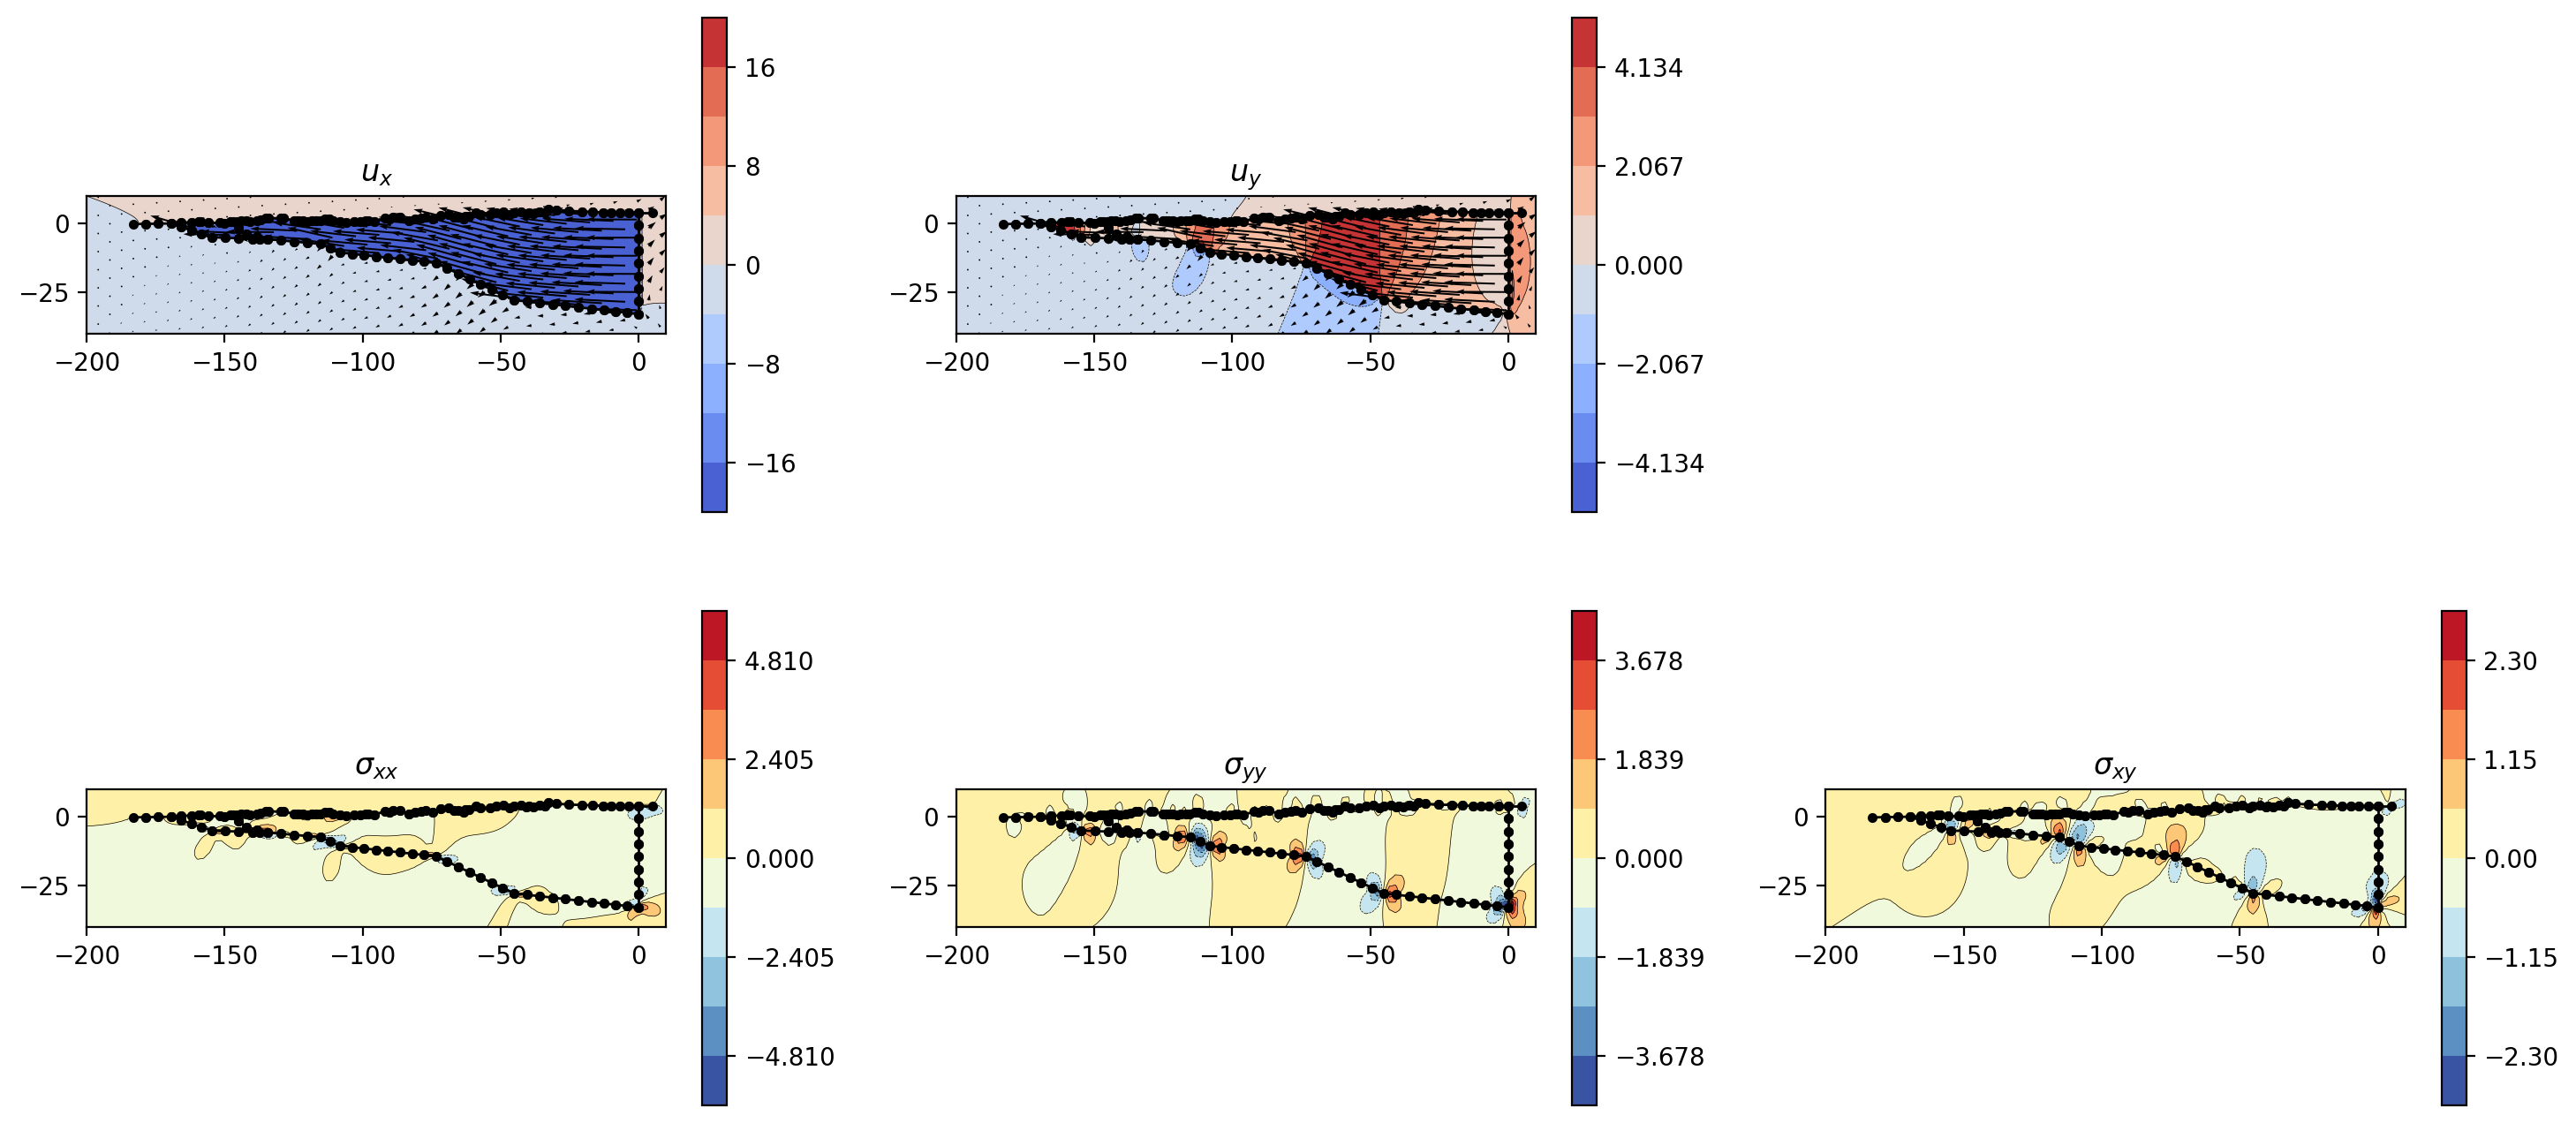

In [23]:
bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot=26
)

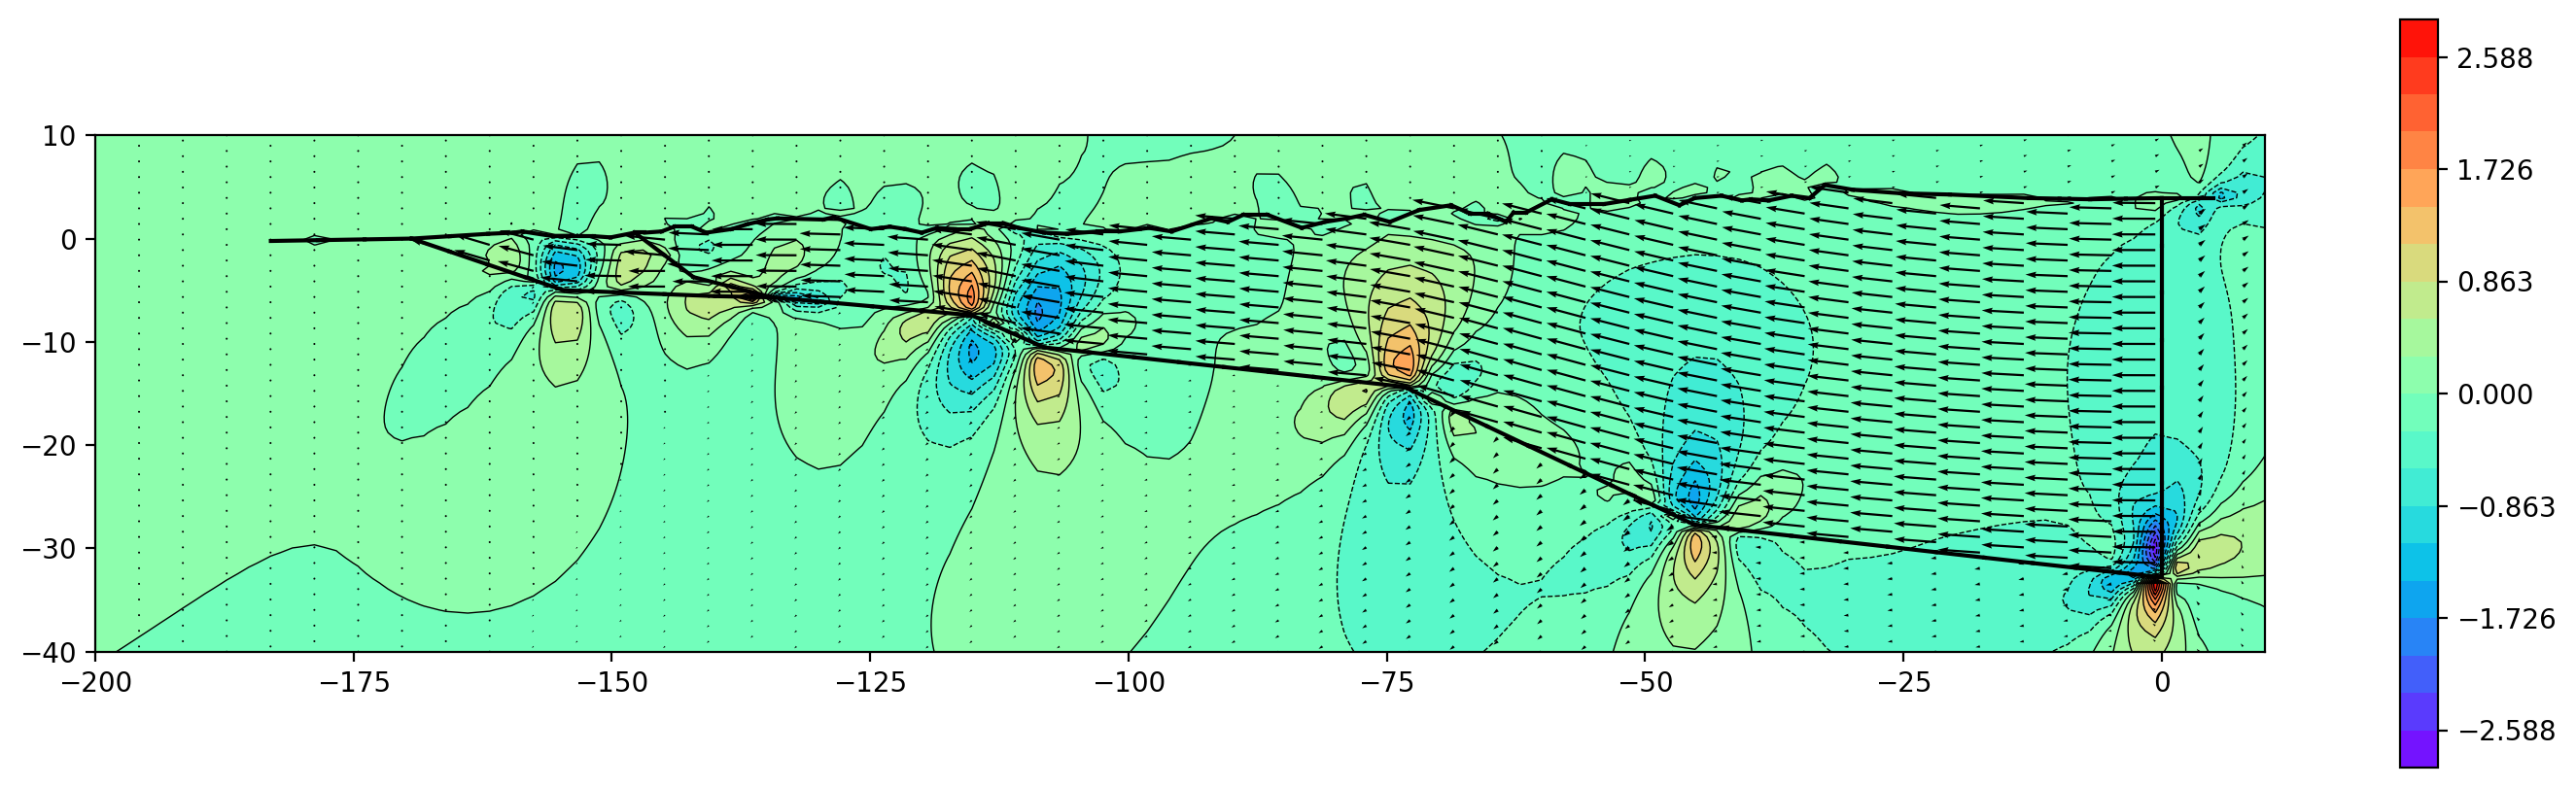

In [35]:
plt.figure(figsize=(18, 5))
# toplot = np.sqrt(ux.reshape(n_obs, n_obs) ** 2 + uy.reshape(n_obs, n_obs) ** 2)
# toplot = uy.reshape(n_obs, n_obs)
toplot = sxy.reshape(n_obs, n_obs)
maxval = np.max(np.abs(toplot))
minval = -maxval

# print(maxval)
n_skip_plot = 6
img = plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="rainbow",
    vmin=minval,
    vmax=maxval,
    levels=np.linspace(-maxval, maxval, 21),
)
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    linewidths=0.5,
    colors="k",
    levels=np.linspace(-maxval, maxval, 21),
)
plt.colorbar(img)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.xlim([np.min(x_obs), np.max(x_obs)])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.quiver(
    x_obs[0::n_skip_plot],
    y_obs[0::n_skip_plot],
    ux[0::n_skip_plot],
    uy[0::n_skip_plot],
    width=0.001,
    scale=1000,
)
plt.show()

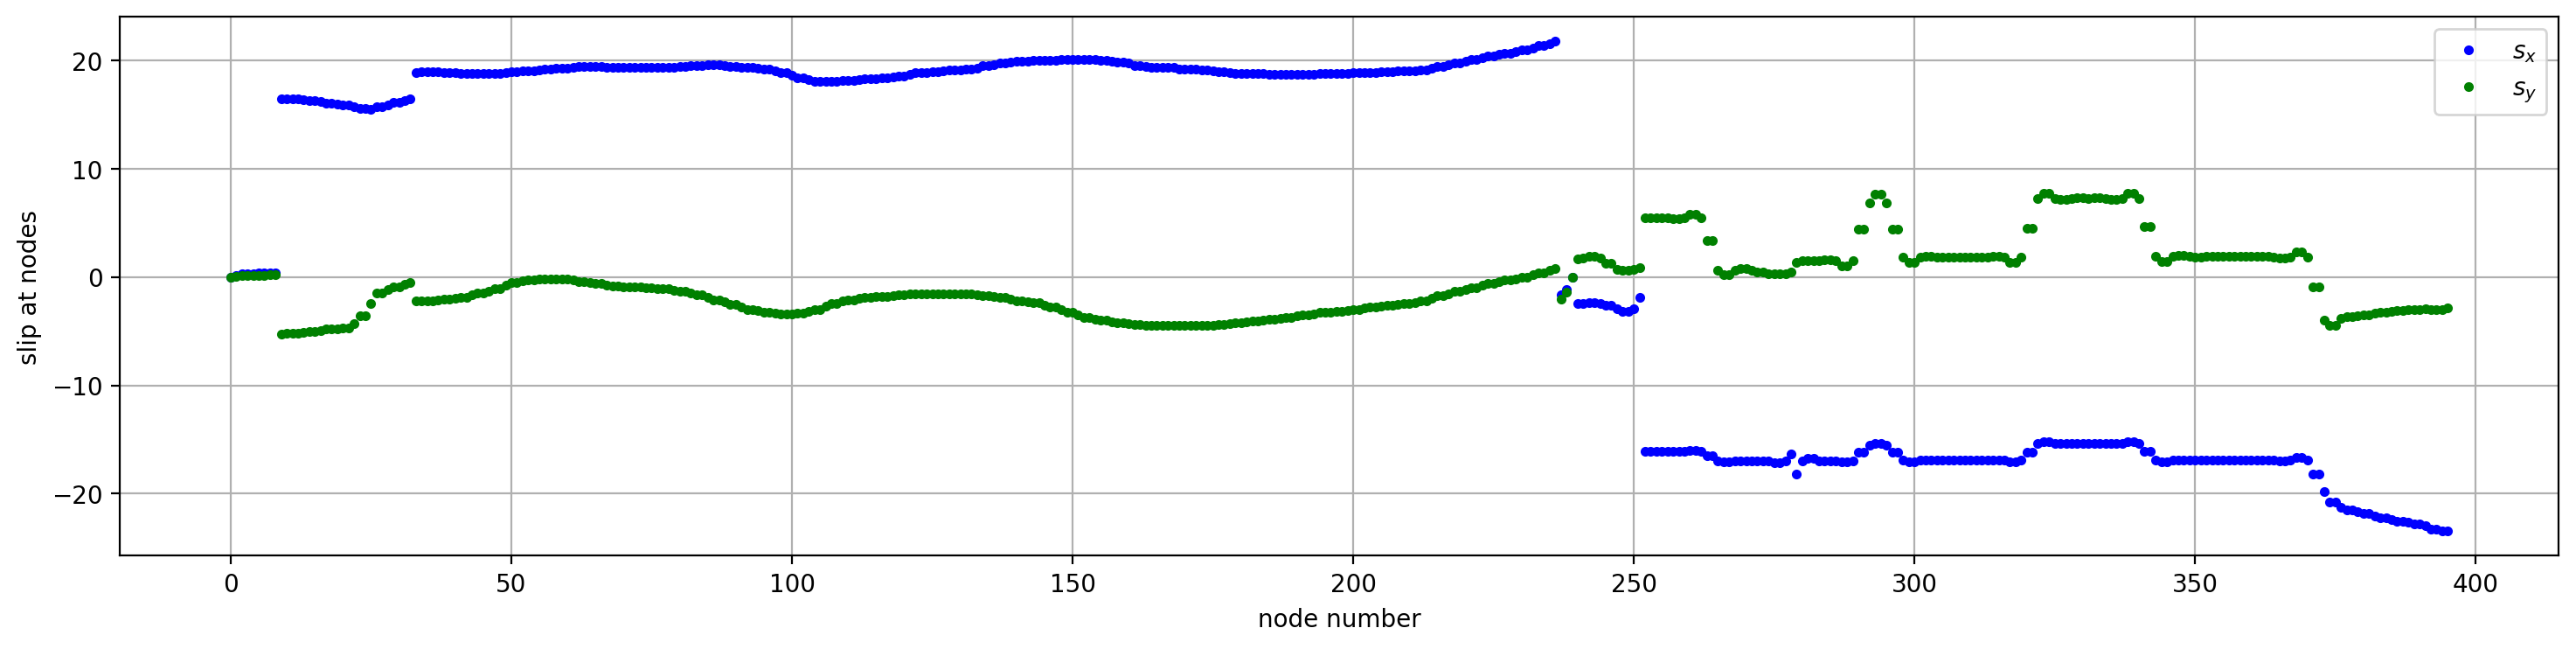

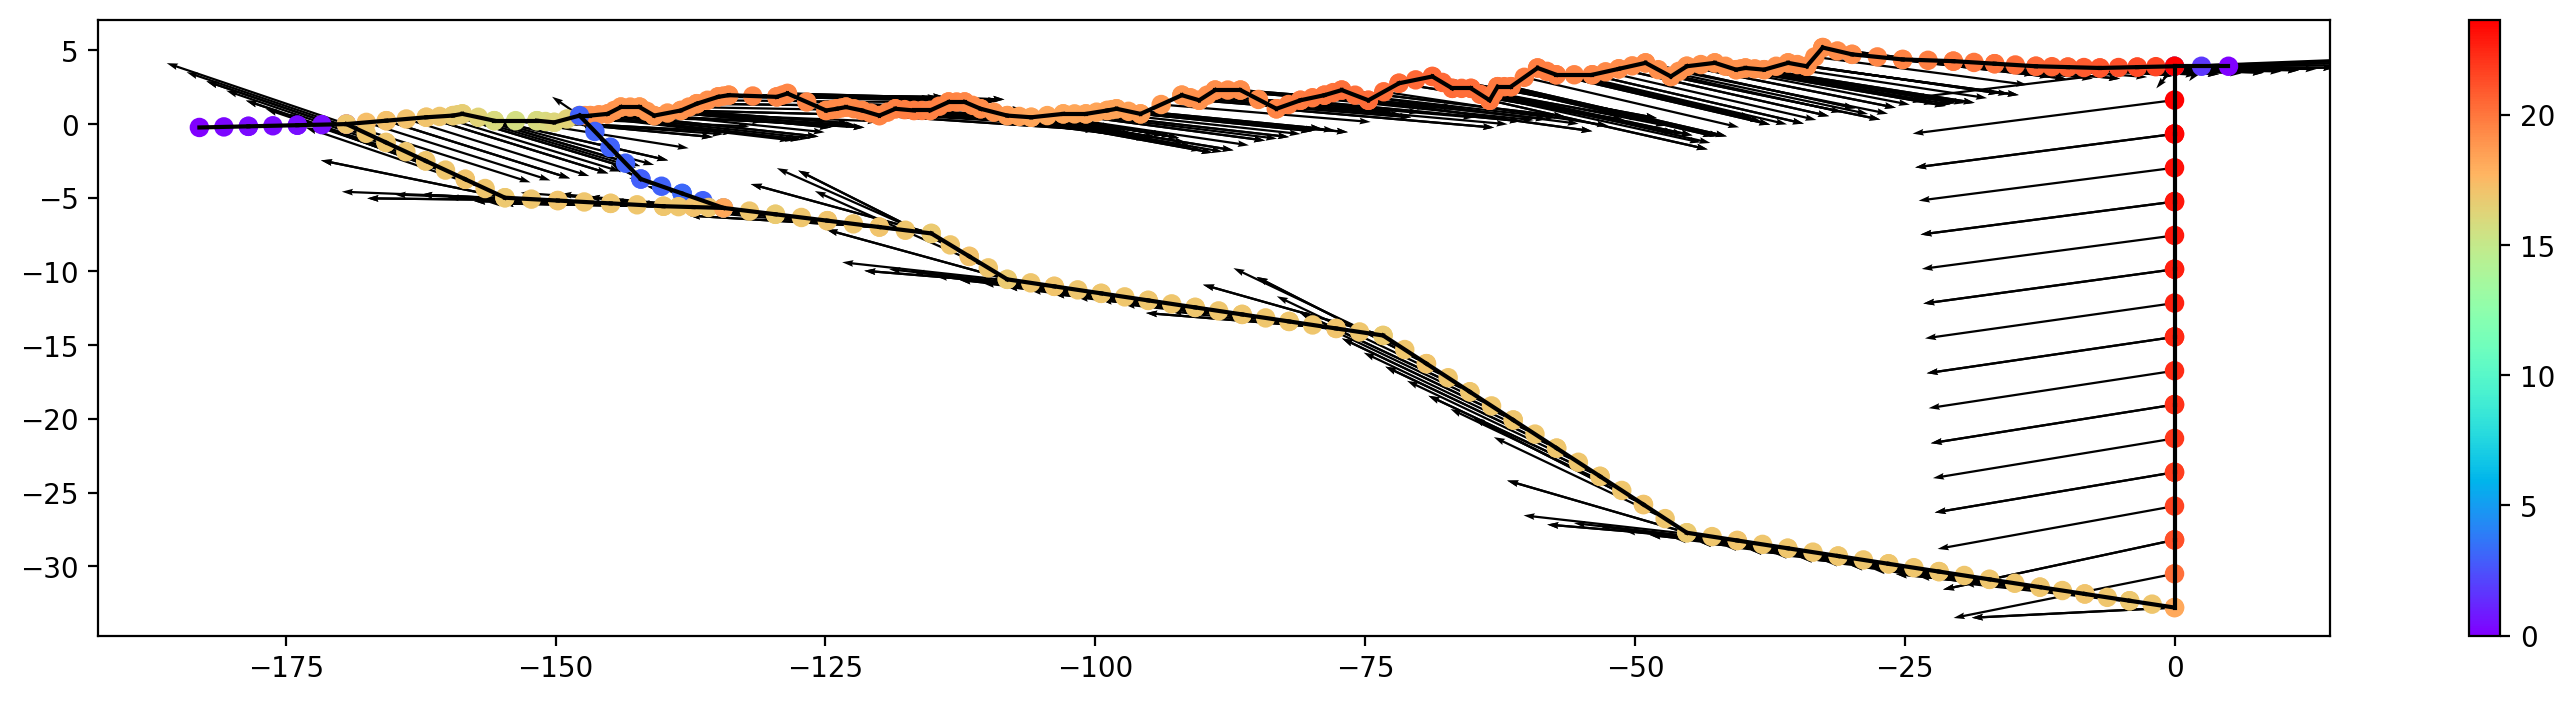

In [34]:
# Extract slip at nodes from quadratic coefficients
slip_nodes = matrix_slip @ quadratic_coefs
slip_nodes_x = slip_nodes[0::2]
slip_nodes_y = slip_nodes[1::2]
slip_vector = np.hstack((slip_nodes_x, slip_nodes_y))
xnodes = np.zeros((3 * n_els, 1))
ynodes = np.zeros((3 * n_els, 1))
xnodes[0::3, 0] = els.x1
xnodes[2::3, 0] = els.x2
xnodes[1::3, 0] = els.x_centers
ynodes[0::3, 0] = els.y1
ynodes[2::3, 0] = els.y2
ynodes[1::3, 0] = els.y_centers

plt.figure(figsize=(18, 4))
plt.plot(slip_nodes_x, "b.", label="$s_x$")
plt.plot(slip_nodes_y, "g.", label="$s_y$")
plt.xlabel("node number")
plt.ylabel("slip at nodes")
plt.legend()
plt.grid()
plt.show()

from matplotlib.colors import LogNorm

plt.figure(figsize=(18, 4))
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-")
plt.quiver(xnodes, ynodes, slip_nodes_x, slip_nodes_y, scale=200, width=0.001)
plt.scatter(
    xnodes,
    ynodes,
    c=np.sqrt(slip_nodes_x**2 + slip_nodes_y**2),
    label="Data Points",
    marker="o",
    cmap="rainbow",
    # norm=LogNorm(vmin=0.1, vmax=50),
)
plt.colorbar()
plt.show()